In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import umap.plot

from umap import UMAP
from sklearn.cluster import HDBSCAN

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python

In [2]:
embed = pickle.load(open('phrase_embeddings.pkl', 'rb'))
embed = [e for e in embed if isinstance(e[2], np.ndarray)]
embed_array = np.vstack([e[2] for e in embed])
embed_norm = normalize(embed_array)

In [3]:
umap_fit = UMAP(
    n_neighbors=30,
    min_dist=0,
    n_components=2,
    metric='cosine',
    random_state=0
)
proj = umap_fit.fit_transform(embed_norm)

In [5]:
hdbscan = HDBSCAN(min_cluster_size = 50, min_samples=40,
                  store_centers='medoid')
hdbscan.fit(proj)

HDBSCAN(min_cluster_size=50, min_samples=40, store_centers='medoid')

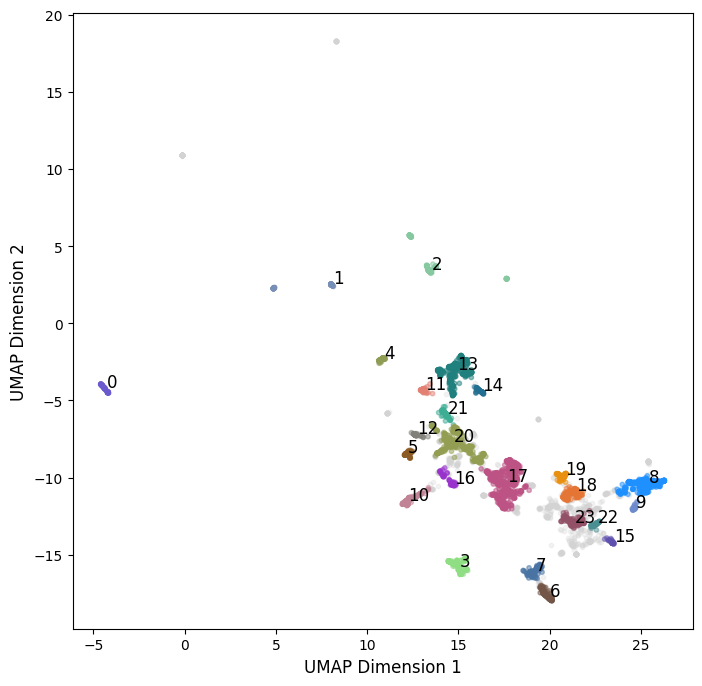

In [6]:
c_labels = np.sort(np.unique(hdbscan.labels_))
n_c = len(c_labels)

cmap = mpl.colors.LinearSegmentedColormap.from_list("", 
    ["slateblue", "lightgreen", "saddlebrown", "dodgerblue",  
     "salmon", "teal",  "darkorchid", "darkorange", 
     "lightseagreen", "crimson"]
)

# define the colormap
# cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,n_c,n_c+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(8,8))

c_idx_noise = np.where(hdbscan.labels_ == -1)[0]
c_idx_noise_labels = hdbscan.labels_[c_idx_noise]
proj_c_noise = proj[c_idx_noise,:]
scat = ax.scatter(proj_c_noise[:,0], proj_c_noise[:,1], alpha=0.25,
                  color='lightgray', s=10)

c_idx = np.where(hdbscan.labels_ != -1)[0]
c_idx_labels = hdbscan.labels_[c_idx]
proj_c = proj[c_idx,:]
scat = ax.scatter(proj_c[:,0], proj_c[:,1], alpha=0.5, c=c_idx_labels,
                  cmap=cmap, norm=norm, s=10)

# create the colorbar

# ax.set_title('The Brain is... UMAP Embedding')


for i in range(hdbscan.medoids_.shape[0]):
    medoid_idx = hdbscan.medoids_[i,:]
    ax.text(medoid_idx[0]+0.1, medoid_idx[1]+0.1, i, fontsize=12)

ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)

# for i, c in enumerate(c_labels):
#     c_idx = np.where(hdbscan.labels_ == c)[0]
#     proj_c = proj[c_idx,:]
#     if c == -1:
#         ax.scatter(proj_c[:,0], proj_c[:,1], alpha=0.25, 
#                    s =10, color='gray')
#     else:
#         ax.scatter(proj_c[:,0], proj_c[:,1], alpha=0.25, 
#                    s =10, c=i, cmap='viridis', label=f'Clus {c}')
# ax.legend()
plt.savefig('umap.png', transparent=True)

In [7]:
embed_text = [e[1] for e in embed]
clus = 17
clus_idx = np.where(hdbscan.labels_ == clus)[0]
for i in clus_idx:
    print(embed_text[i])


the brain is a vital organ
the brain is an evolved organ
the brain is a unique tissue in this regard
The brain is the control centre of the body
The brain is an amazing and critical organ for our life
the brain is an active system that entails
the brain is an important future goal for us
the brain is a secondary or spurious referent of such a model
the brain is the origin of the nerves for sensation
the brain is the best organ
the brain is the most important organ
The human brain is a functionally specialized organ with anatomically distinct structures
the human brain is the object of such study
the brain is an isotropic, homogeneous material, which is not the case
the brain is a necessary but not sufficient part of the enactive organism
the brain is a homogeneous tissue
the brain is the most represented
the brain is “split
The brain is the center of the nervous system
the brain is the organ that is responsible for language
the brain is a physical organ
the brain is a highly specialize

In [8]:
doi_list = [e[0] for e in embed]

In [9]:
articles = json.load(open('matched_articles.json', 'rb'))
articles = {a['doi']: a for a in articles}

In [10]:
clus_df = pd.DataFrame({
    'doi': doi_list,
    'journal': [articles[d]['journal'] for d in doi_list],
    'clus': hdbscan.labels_,
    'year': [articles[d]['publication_year'] if 'publication_year' in articles[d] 
             else np.NaN 
             for d in doi_list]
})
selected_clus = [
    0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 
    12, 13, 14, 18, 19, 21, 22, 23
]

# filter out journals w/ infrequent articles (< 20)
clus_df['journal_n'] = clus_df.groupby('journal')['doi'].transform('count')

clus_df =  clus_df.loc[clus_df.journal_n >= 20].copy()

# filter to selected clusters
clus_df = clus_df.loc[clus_df.clus.isin(selected_clus)].copy()

# join clusters 8,9 and clusters 22,23
clus_df['clus'] = clus_df.clus.replace(
    {
        8: 89,
        9: 89,
        22: 2223,
        23: 2223
    }
)

# define cluster label descriptions
clus_labels = {
    0: 'cholesterol-rich', 
    1: 'insulin-sensitive', 
    2: 'metastasis',
    3: 'complex_body', 
    4: 'lipid-rich', 
    5: 'endocrine',
    6: 'heterogenous', 
    89: 'complex-network',
    10: 'immune-privileged',
    11: 'oxygen-demanding',
    12: 'stress-adaptation',
    13: 'high-metabolism',
    14: 'vascularized',
    18: 'information-processor',
    19: 'prediction-machine',
    21: 'oxidative-stress',
    2223: 'dynamic-system'
}

clus_df['clus_label'] = clus_df.clus.replace(clus_labels)

# shorten these journal names
j_short = {
    'International Journal of Environmental Research and Public Health': \
    'I.J. of Environmental Research and Public Health',
    'Evidence-based Complementary and Alternative Medicine : eCAM': 'eCAM'
}
clus_df['journal'] = clus_df.journal.replace(j_short)

# calculate crosstab
cj_ct = pd.crosstab(clus_df['journal'], clus_df['clus_label'])

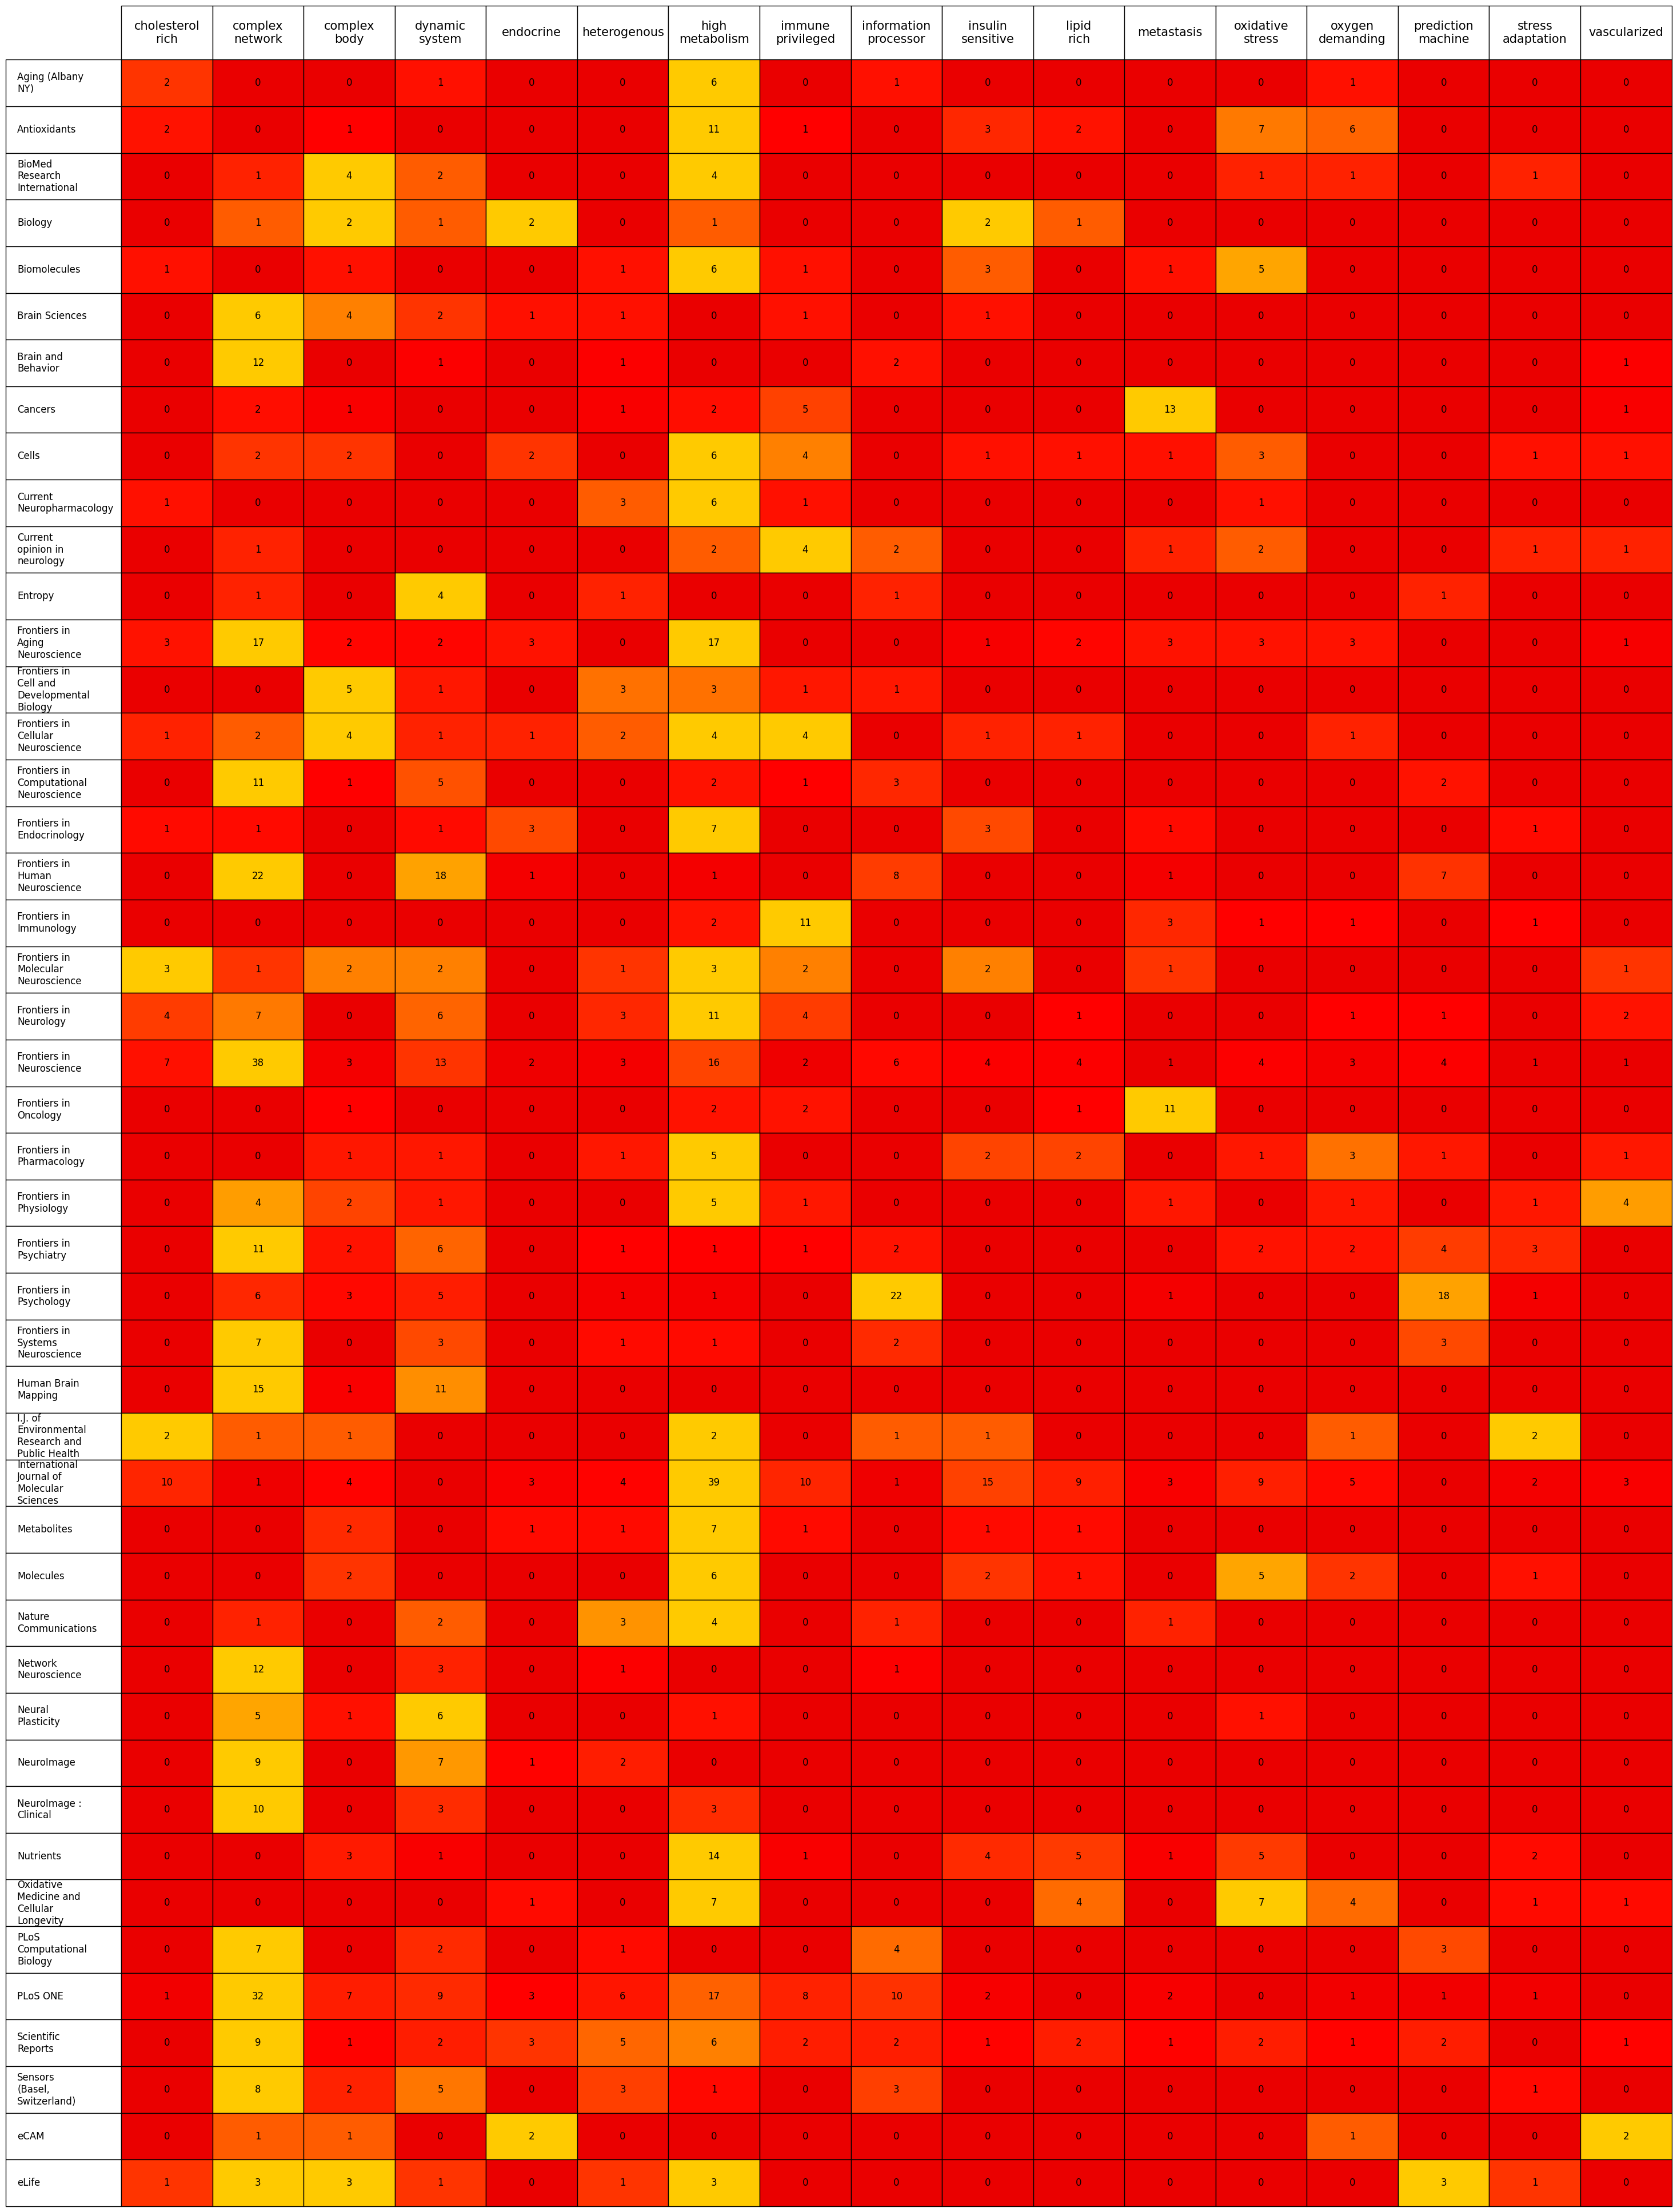

In [11]:
import textwrap

cj_ct_norm=cj_ct.sub(cj_ct.min(axis=1), axis=0).div((cj_ct.max(axis=1)-cj_ct.min(axis=1)), axis=0)

norm = plt.Normalize(cj_ct_norm.values.min()-1, cj_ct_norm.values.max()+1)
colours = plt.cm.hot(norm(cj_ct_norm.values))

fig, ax = plt.subplots(figsize=(35,50))
ax.axis('off')

# create new lines to fit text labels in cells
wrapper = textwrap.TextWrapper(width=14, break_long_words=False)
j_newline = [wrapper.fill(text=j) for j in cj_ct.index]
c_newline = [c.replace('-', '\n').replace('_', '\n') for c in cj_ct.columns]


table = ax.table(
    cellText=cj_ct.values, rowLabels=j_newline, 
    colLabels=c_newline, colWidths = [0.01]*cj_ct.shape[1], 
    cellColours=colours, cellLoc='center', bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(12)
# table.scale(2, 2)

cells = table._cells
for cell in table._cells:
    if cell[0] == 0:
        table._cells[cell].set_fontsize(15)
        table._cells[cell].set_height(0.005)
    elif cell[1] == -1:
        table._cells[cell].set_fontsize(12)
        
# table.auto_set_column_width(col=list(range(len(cj_ct.columns))))
plt.show()


In [12]:
section_label = []
for id in articles:
    a = articles[id]
    if 'text' in a:
        for t in a['text']:
            if any([s in a['text'][t] for s in a['matched_sent']]):
                section_label.append(t.strip().lower())
    else:
        section_label.append('abstract')

import re

section_label = [re.sub("[0-9,.:;?!\"' ]",'', s) for s in section_label]
standard_sections = ['result', 'introduction', 'method', 'materials', 'discussion', 
                     'conclusion' ,'background']
section_label_standard = [
    s for s in section_label 
    if any([std in s for std in standard_sections])
]

In [15]:
pd.Series(section_label).value_counts(normalize=True)

introduction                                0.324144
discussion                                  0.133012
abstract                                    0.096715
                                            0.032391
background                                  0.022283
                                              ...   
enzymereplacementtherapy(ert)               0.000230
alteredfunctionalconnectivitybetweenrsns    0.000230
functionalconnectivityanalyses              0.000230
temozolomide                                0.000230
definitionofdeath                           0.000230
Name: proportion, Length: 1610, dtype: float64

In [14]:
len(section_label_standard)/len(section_label)

0.5063174821961866

In [21]:
np.savetxt('matched_expressions.txt', embed_text, fmt='%s')

In [22]:
from glob import glob

In [25]:
xml_files = glob('data/filtered/PMC*.json')

In [27]:
total_c = 0
for f in xml_files:
    a = json.load(open(f, 'rb'))
    total_c += len(a)

In [28]:
total_c

561836